## Imports

In [25]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

## Define Functions

In [26]:
# define evaluation function
def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    
    print("Accuracy:    ", accuracy)
    print("F1-Score:    ", f1)
    print("Precision:   ", precision)
    print("Recall:      ", recall)
    print()
    print(classification_report(y_test, y_pred))
    print()

    disp.plot()

## Load .csv into DF

In [27]:
# load data into dataframe
df = pd.read_csv("phishing_email_projectthesis.csv") 

## Prepare Data

In [28]:
# rename columns
df = df.rename(columns={'text_combined': 'content'}).rename(columns={'label': 'target'}) 

In [29]:
# drop duplicates but keep the first
df = df.drop_duplicates(keep='first') 

In [30]:
# randomized undersampling
df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)

/var/folders/gr/nkq2fp191y1_3wywjp14_sz00000gn/T/ipykernel_1722/842751370.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)


## Split Data into Training and Test 80-20

In [31]:
# define X and Y
X = df['content']
y = df['target']

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (62772,)
Shape of X_test: (15694,)
Shape of y_train: (62772,)
Shape of y_test: (15694,)


## Vektorize with TF-IDF

In [32]:
# creating vectorizer object with standart parameters
vectorizer = TfidfVectorizer()

# fit on and tranform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# transform test data 
X_test_tfidf = vectorizer.transform(X_test)

## Multi Layer Perceptron

/Users/nikobiebl/.local/share/virtualenvs/Project-Thesis-PGQKRxl5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:     0.9962406015037594
F1-Score:     0.9962317174426774
Precision:    0.9961680929876102
Recall:       0.9962953500255494

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7866
           1       1.00      1.00      1.00      7828

    accuracy                           1.00     15694
   macro avg       1.00      1.00      1.00     15694
weighted avg       1.00      1.00      1.00     15694




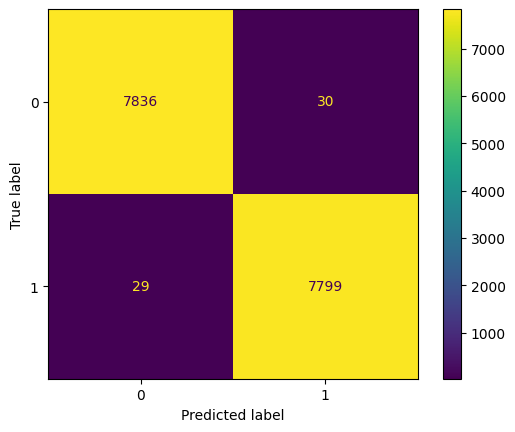

In [59]:
# create classifier object
mlp_tfidf_classifier = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=5,random_state=42)

# train classifier
mlp_tfidf_classifier.fit(X_train_tfidf, y_train)

# test classifier
mlp_tfidf_predictions = mlp_tfidf_classifier.predict(X_test_tfidf)

# evaluate
evaluate(mlp_tfidf_predictions)

## Creating Treshold Evaluation

In [41]:
probabilities = mlp_tfidf_classifier.predict_proba(X_test_tfidf)

probabilities_0 = probabilities[:, 0]
probabilities_1 = probabilities[:, 1]

actual_values = y_test

probabilities_and_values_df = pd.DataFrame({
    'probabilities_0': probabilities_0,
    'probabilities_1': probabilities_1,
    'actual_values': actual_values
})

print(probabilities_and_values_df.shape)
print(probabilities_and_values_df.head(20))

(15694, 3)
       probabilities_0  probabilities_1  actual_values
30578         0.999153         0.000847              0
75285         0.001673         0.998327              1
47368         0.017618         0.982382              1
23969         0.998966         0.001034              0
53099         0.011854         0.988146              1
14076         0.992542         0.007458              0
20565         0.988225         0.011775              0
62974         0.013711         0.986289              1
55285         0.002055         0.997945              1
61165         0.005221         0.994779              1
49031         0.017565         0.982435              1
65834         0.004742         0.995258              1
64319         0.008453         0.991547              1
63695         0.000791         0.999209              1
77050         0.002538         0.997462              1
15197         0.992392         0.007608              0
9908          0.997671         0.002329              0

In [42]:
under_60_percent_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] < 0.6) & (probabilities_and_values_df['probabilities_1'] < 0.60)]

print(under_60_percent_df.shape)
print(under_60_percent_df.head(22))

(88, 3)
       probabilities_0  probabilities_1  actual_values
37645         0.593714         0.406286              0
30282         0.440991         0.559009              0
51980         0.502553         0.497447              1
21564         0.419556         0.580444              0
60885         0.553936         0.446064              1
37935         0.541618         0.458382              0
2107          0.590423         0.409577              0
36478         0.415059         0.584941              0
61891         0.544561         0.455439              1
65646         0.547143         0.452857              1
10406         0.571553         0.428447              0
21104         0.586314         0.413686              0
42265         0.423314         0.576686              1
18138         0.453339         0.546661              0
68458         0.499897         0.500103              1
68747         0.432196         0.567804              1
8248          0.415059         0.584941              0
19

In [43]:
thresholds = np.arange(0.5, 1.0, 0.01)

results = []

for threshold in thresholds:

    classifiable_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] > threshold) | (probabilities_and_values_df['probabilities_1'] > threshold)]
    
    percentage_classifiable = (len(classifiable_df) / len(probabilities_and_values_df)) * 100
    
    predicted_labels = np.where(classifiable_df['probabilities_1'] > threshold, 1, 0)

    accuracy = accuracy_score(classifiable_df['actual_values'], predicted_labels) * 100
    precision = precision_score(classifiable_df['actual_values'], predicted_labels) * 100
    recall = recall_score(classifiable_df['actual_values'], predicted_labels) * 100
    f1 = f1_score(classifiable_df['actual_values'], predicted_labels) * 100

    results.append({
        'threshold': threshold,
        'classifiable': percentage_classifiable,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

print(results_df.head(50))

    threshold  classifiable    accuracy   precision      recall          f1
0        0.50    100.000000   99.311839   99.159450   99.463464   99.311224
1        0.51     99.942653   99.343322   99.184402   99.501406   99.342651
2        0.52     99.904422   99.362204   99.209688   99.514129   99.361675
3        0.53     99.840703   99.406471   99.247449   99.564939   99.405941
4        0.54     99.802472   99.425397   99.285350   99.564884   99.424920
5        0.55     99.713266   99.476005   99.310521   99.641302   99.475636
6        0.56     99.643176   99.494820   99.322857   99.666667   99.494465
7        0.57     99.592201   99.526552   99.373482   99.679364   99.526188
8        0.58     99.541226   99.545513   99.398746   99.692071   99.545192
9        0.59     99.496623   99.570925   99.449635   99.692071   99.570705
10       0.60     99.439276   99.589901   99.487771   99.692031   99.589796
11       0.61     99.401045   99.602564   99.500384   99.704750   99.602462
12       0.6